# Quiroga

In [1]:
# 1440000길이의 리스트 (24kHz로 60초동안 샘플링한 데이터)
# 파형이 16개고 파형당 당연히 채널 1개, 유닛 3개.

import numpy as np
import matplotlib.pyplot as plt
from scipy import io
import os
from collections import Counter
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

def seed_assign(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

data_path = '/data2/spike_sorting/quiroga/'

filename = ["C_Easy1_noise005.mat", "C_Easy1_noise01.mat", "C_Easy1_noise015.mat", "C_Easy1_noise02.mat",
            "C_Easy2_noise005.mat", "C_Easy2_noise01.mat", "C_Easy2_noise015.mat", "C_Easy2_noise02.mat",
            "C_Difficult1_noise005.mat", "C_Difficult1_noise01.mat", "C_Difficult1_noise015.mat", "C_Difficult1_noise02.mat",
            "C_Difficult2_noise005.mat", "C_Difficult2_noise01.mat", "C_Difficult2_noise015.mat", "C_Difficult2_noise02.mat"]

# filename = ["C_Easy1_noise005.mat", "C_Easy1_noise01.mat", "C_Easy1_noise015.mat", "C_Easy1_noise02.mat",
#             "C_Easy1_noise025.mat", "C_Easy1_noise03.mat", "C_Easy1_noise035.mat", "C_Easy1_noise04.mat",
#             "C_Easy2_noise005.mat", "C_Easy2_noise01.mat", "C_Easy2_noise015.mat", "C_Easy2_noise02.mat",
#             "C_Difficult1_noise005.mat", "C_Difficult1_noise01.mat", "C_Difficult1_noise015.mat", "C_Difficult1_noise02.mat",
#             "C_Difficult2_noise005.mat", "C_Difficult2_noise01.mat", "C_Difficult2_noise015.mat", "C_Difficult2_noise02.mat"]

index = 8
current_dataset = data_path+filename[index]
print('현재 데이터 :', current_dataset)
mat1 = io.loadmat(current_dataset)
raw_data = mat1['data'][0]
raw_data = raw_data.reshape(1,-1)
print(f'데이터 길이 : {raw_data.shape}')

sampling_rate = 24000

spike_times_temp = mat1['spike_times'][0][0][0]
spike_label = mat1['spike_class'][0][0][0]

spike_times_int_all_units = []
for i in range(len(np.unique(spike_label))):
    spike_times_int_all_units.append([])
for i in range(len(spike_times_temp)):
    spike_times_int_all_units[spike_label[i]-1].append(spike_times_temp[i])
for i in range(len(np.unique(spike_label))):
    spike_times_int_all_units[i] = np.array(spike_times_int_all_units[i])
    print(f'{i+1}번째 unit spike 개수 : {len(spike_times_int_all_units[i])}')



현재 데이터 : /data2/spike_sorting/quiroga/C_Difficult1_noise005.mat
데이터 길이 : (1, 1440000)
1번째 unit spike 개수 : 1115
2번째 unit spike 개수 : 1113
3번째 unit spike 개수 : 1155


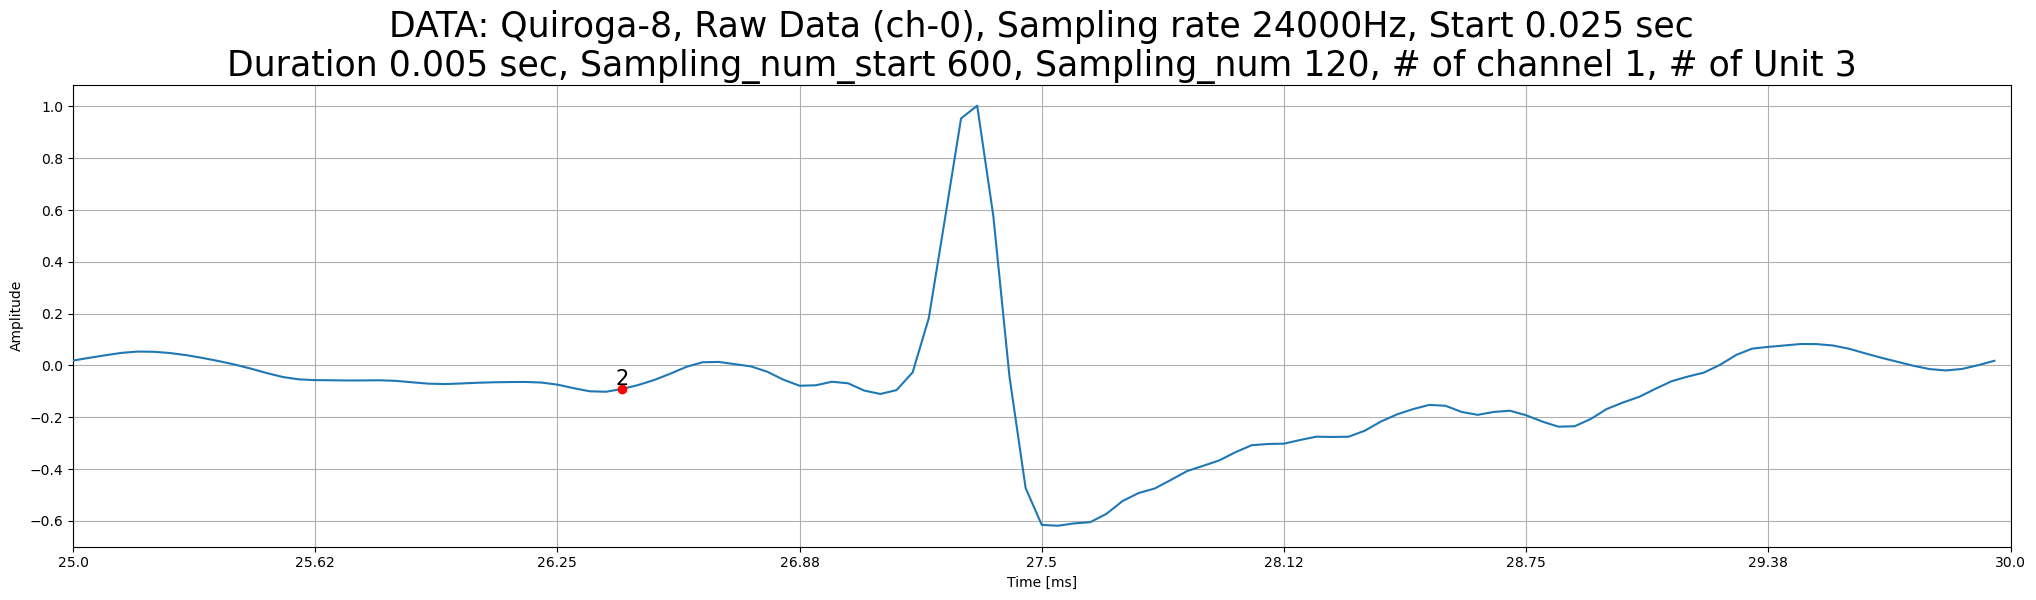

In [2]:
## 데이터 슬라이스 해서 보자 (너무 많잖아)
# for ch in range(raw_data_sliced.shape[0]):
for ch in range(1):
    what_channel = ch
    sampling_start = 0.025 # 초 # 언제부터 볼지
    sampling_second = 0.005 # 초 # 얼마나 볼지
    sampling_rate = sampling_rate

    sampling_num_start = int(sampling_start * sampling_rate)
    sampling_num = int(sampling_second * sampling_rate)

    raw_data_sliced = raw_data[:, sampling_num_start:sampling_num_start+sampling_num]
    # print('raw_data_sliced', raw_data_sliced.shape)

    filtered_spike_times_int_all_units = [np.array(spike_times)[(sampling_num_start <= np.array(spike_times)) & (np.array(spike_times) < sampling_num_start+sampling_num)] for spike_times in spike_times_int_all_units]




    import matplotlib.pyplot as plt
    # 플로팅
    one_channel = raw_data_sliced[what_channel]
    truth = filtered_spike_times_int_all_units

    plt.figure(figsize=(25, 6))
    plt.plot(np.arange(len(one_channel)) , one_channel, zorder = 50, label="Raw Data")  
    plt.xlim(0, sampling_num)
    # 가로축 간격 설정
    x_min, x_max = plt.xlim()  # 현재 x축 범위 가져오기
    x_interval = (x_max-x_min)/8  # 원하는 x축 간격 (데이터 포인트 기준)
    plt.xticks(np.arange(x_min, x_max + x_interval, x_interval))  # 간격에 따라 눈금 설정

    plt.title(f"DATA: {'Quiroga'}-{index}, Raw Data (ch-{what_channel}), Sampling rate {sampling_rate}Hz, Start {sampling_start} sec\nDuration {sampling_second} sec, Sampling_num_start {sampling_num_start}, Sampling_num {sampling_num}, # of channel {1}, # of Unit {len(spike_times_int_all_units)}", fontsize=25)
    plt.xlabel("Time [ms]")
    plt.ylabel("Amplitude")
    plt.grid(True)

    for idx, spike_times in enumerate(truth):
        spike_times = spike_times - sampling_num_start
        plt.scatter(spike_times, one_channel[spike_times], zorder=120, color='r', label=f"Trigger {idx}")
        for time in spike_times:
            plt.text(time, one_channel[time], str(idx), color='black', zorder=125, fontsize=15, ha='center', va='bottom')


    # x축 눈금 위치는 그대로 두고, 표시되는 숫자만 변경
    xticks = plt.gca().get_xticks()
    new_labels = [round((tick + sampling_num_start) / sampling_rate * 1000, 2) for tick in xticks]
    plt.xticks(ticks=xticks, labels=new_labels)

    plt.show()

# Spampinato (Paired)

juxta fire볼까
데이터 타입: <class 'numpy.ndarray'>
데이터 형태 (shape): (3514,)
데이터 크기 (size): 3514
데이터 타입 (dtype): int64

데이터 일부 미리보기:
[  23846   23919   24029 ... 5997968 5998963 5999290]

데이터 최소값: 23846
데이터 최대값: 5999290
데이터 평균값: 3206288.7316448493
데이터 표준편차: 1756847.257149111

raw data 로딩
(6000000, 256) 5min * 20000Hz
[[-0.2084    -0.4168    -0.8336    ...  1.6672     0.8336     0.       ]
 [ 0.1042    -1.2504     2.7092    ...  3.5428     7.3982    -0.3126   ]
 [ 0.7294    -4.2722     4.2722    ...  5.1057997  8.0234    -0.2084   ]
 ...
 [-5.3142     7.1898    -1.2504    ...  1.2504     6.9814    -0.2084   ]
 [-4.2722     5.6268    -3.9596    ...  0.9378     5.9393997  0.       ]
 [-0.2084     0.         0.2084    ... -0.8336     0.         0.       ]]


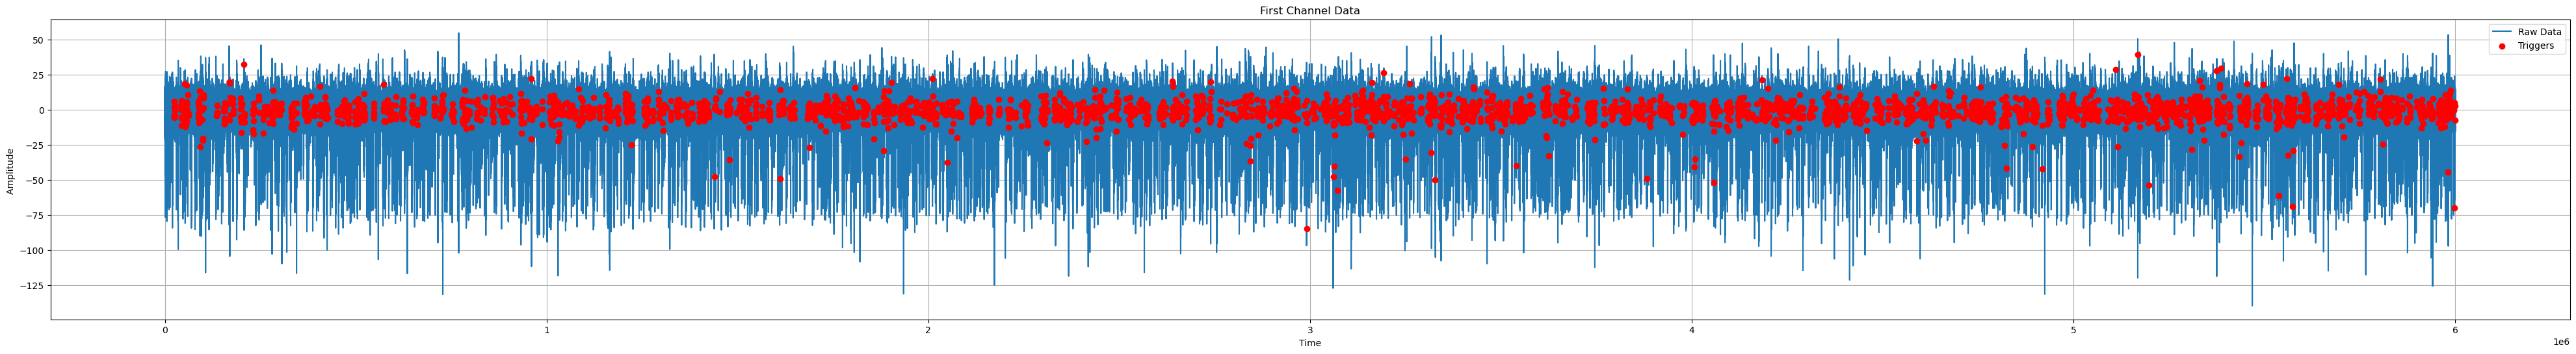


juxta raw보자
(6000000, 2) 이게 왜 120,000개 인지 모르겠다.
[[ 1546.1196   1686.6854 ]
 [ -628.2218   1731.5956 ]
 [ -584.45776  1733.6796 ]
 ...
 [-2933.6467   1730.241  ]
 [ 1546.1196   1726.6981 ]
 [ -671.8816  -1764.9396 ]]

데이터 최소값: -3414.3213
데이터 최대값: 3411.8206
데이터 평균값: -481.123
데이터 표준편차: 1772.4427


In [3]:
## spampinato https://zenodo.org/records/1205233 from https://elifesciences.org/articles/34518
# 이 데이터셋은 마우스 망막에서의 Ganglion Cell의 loose patch 기록과 252채널의 외부 전극 기록을 포함한 in-vitro ground-truth 데이터로, 주로 스파이크 정렬(spike sorting) 알고리즘의 성능을 평가하기 위해 사용됩니다. 이 데이터셋에 대한 세부 사항을 이해하려면 다음의 정보를 참고할 수 있습니다.

# 프로브 레이아웃 (Probe Layout)
# mea_256.prb 파일은 16x16 형태의 **Multi Electrode Array (MEA)**를 나타냅니다.
# 각 전극의 간격은 30μm입니다.
# 252채널은 외부 전극 신호를 기록하는데 사용되며, 나머지 4개의 코너는 trigger/sync/juxta 신호를 위한 채널로 할당됩니다.
# 데이터 구조 (Structure of the Data)
# 이 데이터셋에는 여러 개의 개별 기록이 포함되어 있으며, 각 기록은 최대 5분 길이입니다. 각 데이터 파일은 다음과 같은 내용을 포함합니다:

# 이미지 파일: juxta-cellular signal의 작은 조각과 그에 대한 detect peaks 및 threshold가 표시됩니다. 또한, **Spike Triggered Average (STA)**가 나타나는 채널에서의 전압 변화를 보여주는 이미지도 포함됩니다.

# juxta.raw 파일: juxta-cellular trace를 20kHz 샘플링 주기로 저장한 파일이며, 데이터 오프셋이 없습니다 (float32 형식).

# raw 파일: 20kHz 샘플링 주기로 기록된 256채널의 외부 전극 신호를 포함하는 파일입니다. 실제로는 252개의 채널만 외부 전극 신호를 기록하고, 나머지 4개의 채널은 juxta-cellular 및 sync 신호를 기록하는 데 사용됩니다 (uint16 형식).

# triggers.npy 파일: juxta-cellular spikes의 스파이크 시간을 담고 있으며, 이들은 k.MAD 방식의 threshold로 감지된 결과입니다. 이때 k 값은 각 데이터셋마다 다를 수 있으며, 이 값은 .txt 파일에 기록되어 있습니다.

# txt 파일: 각 데이터셋에 대한 정보가 포함되어 있으며, 여기에는 스파이크 감지를 위한 threshold 값, juxta-cellular 신호가 위치한 채널, **Spike Triggered Average (STA)**의 최소 피크 값 및 해당 채널에 대한 정보, 그리고 raw 데이터를 읽을 때 필요한 헤더 크기 등이 포함됩니다.

# params 파일: SpyKING CIRCUS로 데이터를 분석할 때 사용되는 설정 파일입니다.

import numpy as np

# 파일 경로 설정
print("juxta fire볼까")
file_path = "/data2/spike_sorting/spampinato/20160415_patch2/patch_2_MEA.triggers.npy"

# .npy 파일 열기
data = np.load(file_path)

# 데이터 구조 분석
print("데이터 타입:", type(data))
print("데이터 형태 (shape):", data.shape)
print("데이터 크기 (size):", data.size)
print("데이터 타입 (dtype):", data.dtype)

# 데이터 미리보기
print("\n데이터 일부 미리보기:")
print(data)  # 처음 10개의 값 출력
truth = data

# 통계 정보
if np.issubdtype(data.dtype, np.number):  # 숫자 데이터일 경우
    print("\n데이터 최소값:", np.min(data))
    print("데이터 최대값:", np.max(data))
    print("데이터 평균값:", np.mean(data))
    print("데이터 표준편차:", np.std(data))
else:
    print("\n데이터는 숫자 형식이 아닙니다.")

#Using the offset value from the txt file, we can load the data with memmap arrays
import numpy
# offset에 padding value
print("\nraw data 로딩")
data=numpy.memmap('/data2/spike_sorting/spampinato/20160415_patch2/patch_2_MEA.raw', dtype='uint16', offset=1871, mode='r')

# print("한 채널만 보자")
# #Then for example, to display the first second of channel 0
# one_channel = data[:20000, 0].astype('float32')

# #If we want to center data around 0
# one_channel -= 2**15 - 1

# #And if we want to display data in micro volt, we must use the gain factor of 0.1042 provided in the header
# one_channel *= 0.1042

# one_channel.shape
# offset에 padding value
data=data.reshape(len(data)//256, 256)
data = data.astype('float32')
data = data - (2**15 - 1)
data = data * 0.1042
print(data.shape, "5min * 20000Hz")
print(data)

import matplotlib.pyplot as plt
# raw data에서 첫 번째 채널을 선택
one_channel = data[:, 0]  # 첫 번째 채널 (0번 인덱스)
time = np.arange(len(one_channel)) 

# 플로팅
plt.figure(figsize=(50, 6))
plt.plot(time, one_channel, zorder = 50, label="Raw Data")  
plt.title("First Channel Data")
plt.xlabel("Time")
plt.ylabel("Amplitude ")
plt.grid(True)
# 트리거 시간 표시 (x축에 표시)
plt.scatter(truth, one_channel[truth], zorder = 120, color='r', label="Triggers")  
plt.legend()
plt.show()


#Using the offset value from the txt file, we can load the data with memmap arrays
import numpy
# 그냥 raw offset에 padding value
print('\njuxta raw보자')
data=numpy.memmap('/data2/spike_sorting/spampinato/20160415_patch2/patch_2_MEA.juxta.raw', dtype='uint16', mode='r')
data=data.reshape(len(data)//2, 2) 
data = data.astype('float32')
data = data - (2**15 - 1)
data = data * 0.1042

print(data.shape, "이게 왜 120,000개 인지 모르겠다.")
print(data)

if np.issubdtype(data.dtype, np.number):  # 숫자 데이터일 경우
    print("\n데이터 최소값:", np.min(data))
    print("데이터 최대값:", np.max(data))
    print("데이터 평균값:", np.mean(data))
    print("데이터 표준편차:", np.std(data))
else:
    print("\n데이터는 숫자 형식이 아닙니다.")

# print(data[:,0])
# print(data[:,1])

# Paired dataset from spike_forest through kachery_cloud

In [4]:
# # One-time initialization (alternate method)
# import kachery_cloud as kcl
# kcl.init()


In [5]:
# One-time initialization (alternate method)
import kachery_cloud as kcl
kcl.init()

# Follow the instructions to associate the client with your GitHub user on the kachery-cloud network


## kachery-cloud load 예시 (근데 다른 주소로는 잘 안된다 짜증나게)
import kachery_cloud as kcl

local_fname = kcl.load_file('sha1://b971c6ef19b1d70ae8f0feb989b106c319b36230?label=test_content.txt')

text = kcl.load_text('sha1://d9e989f651cdd269d7f9bb8a215d024d8d283688?label=example.txt')
# example text

x = kcl.load_json('sha1://d0d9555e376ff13a08c6d56072808e27ca32d54a?label=example.json')
# {'example': 'dict'}

y = kcl.load_npy("sha1://bb55205a2482c6db2ace544fc7d8397551110701?label=example.npy")
# [[1 2 3], [4 5 6]]

z = kcl.load_pkl("sha1://20d178d5a1264fc3267e38ca238c23f3e2dcd5d2?label=example.pkl")
# {'example': array([[1, 2, 3], [4, 5, 6]], dtype=int16)}



print('local_frame:', local_fname)
print('text:', text)
print('x:', x)
print('y:', y)
print('z:', z)



This client has already been registered.
Click the following link to configure the client:
https://kachery-gateway.figurl.org/client/f9a6532c4434fae03413ea1fbcf4904744badbae1bef38fb0823b478ea82eb90

Client ID: f9a6532c4434fae03413ea1fbcf4904744badbae1bef38fb0823b478ea82eb90
Label: chanel
Owner: bhkim003

* Kachery-cloud is intended for collaborative sharing of data for scientific research. It should not be used for other purposes.
local_frame: /home/bhkim003/.kachery-cloud/sha1/b9/71/c6/b971c6ef19b1d70ae8f0feb989b106c319b36230
text: example text
x: {'example': 'dict'}
y: [[1 2 3]
 [4 5 6]]
z: {'example': array([[1, 2, 3],
       [4, 5, 6]], dtype=int16)}


데이터 로드 성공!
데이터 타입: <class 'numpy.ndarray'>
데이터 크기/구조: (32, 8922830)

데이터 미리보기:
[[ -738 -1469 -1602 ...  -460  -465  -425]
 [ -674 -1336 -1683 ...  -386  -344  -307]
 [ -621 -1363 -1687 ...  -400  -401  -318]
 [ -759 -1291 -1773 ...  -415  -373  -410]
 [ -964 -1636 -1976 ...  -403  -379  -413]]

최소값: -12076
최대값: 4390
평균값: -0.5959040041108035
데이터 타입: int16


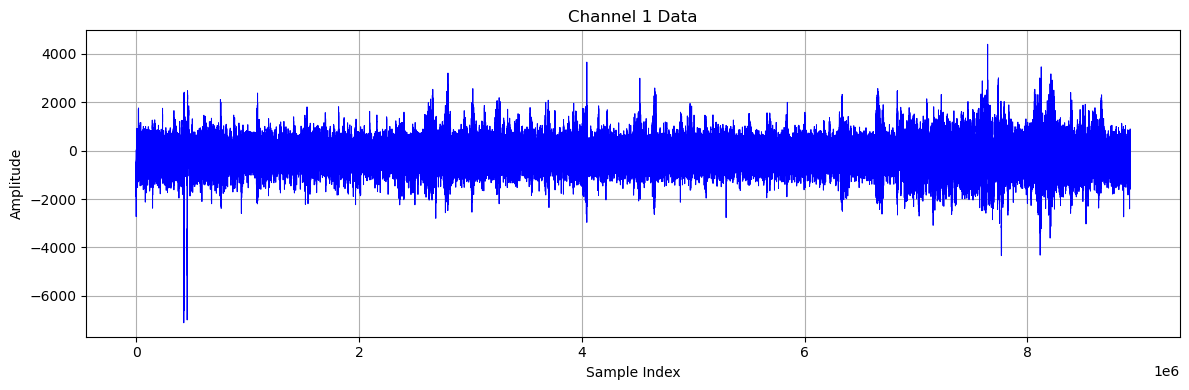

In [6]:
## PAIRED_ENGLISH
import numpy as np

# 파일 경로
file_path = '/data2/spike_sorting/spike_forest/PAIRED_ENGLISH/paired_english/m14_190326_155432.npy'

# .npy 파일 로드
try:
    data = np.load(file_path, allow_pickle=True)
    print("데이터 로드 성공!")
    print(f"데이터 타입: {type(data)}")
    print(f"데이터 크기/구조: {data.shape if hasattr(data, 'shape') else '알 수 없음'}")
    
    # 데이터 미리보기
    print("\n데이터 미리보기:")
    if isinstance(data, np.ndarray):
        print(data[:5])  # 처음 5개 요소만 출력
    elif isinstance(data, list):
        print(data[:5])  # 리스트인 경우 처음 5개만 출력
    else:
        print("데이터 형식이 예상과 다릅니다:", data)
    
    # 상세 분석
    if isinstance(data, np.ndarray):
        print("\n최소값:", data.min())
        print("최대값:", data.max())
        print("평균값:", data.mean())
        print("데이터 타입:", data.dtype)
except Exception as e:
    print("데이터 로드 중 오류 발생:", e)


import matplotlib.pyplot as plt

# 특정 채널 선택 (예: 첫 번째 채널)
channel_index = 0  # 0부터 시작 (첫 번째 채널)

# 선택된 채널 데이터
channel_data = data[channel_index]

# 플롯
plt.figure(figsize=(12, 4))
plt.plot(channel_data, color='blue', linewidth=0.7)
plt.title(f"Channel {channel_index + 1} Data")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
## 이 글에서 설명된 문제와 해결책을 참고하여 kachery로 데이터를 다운로드하는 과정에서 발생할 수 있는 문제를 해결할 수 있는 방법을 안내드리겠습니다.

# 문제 요약:
# kachery로 데이터를 다운로드할 때 일부 파일만 다운로드되고, 다른 파일들은 다운로드되지 않거나 None으로 반환되는 문제 발생.
# 특히, sha1dir:// 형식의 URL로 시작하는 주소에서 문제가 발생하고, sha1:// URL로도 다운로드가 제대로 되지 않는 경우 있음.
# 또한, firings_true.json 파일들이 이상하게 동일한 파일로 지정되어 있음.
# 해결 방법:
# sha1dir://과 sha1:// URL 차이점:

# sha1://는 kachery에서 사용하는 올바른 URL 형식입니다. 반면 sha1dir://는 오래된 형식으로, 현재는 제대로 작동하지 않습니다. 문제의 URL이 sha1dir://로 시작하는 경우, 이를 sha1://로 바꾸어야 합니다.
# 예를 들어, sha1dir://abc900f5cd62436e7c89d914c9f36dcd7fcca0e7.synth_bionet/bionet_static/static_8x_A_2A/raw.mda 주소를 sha1://abc900f5cd62436e7c89d914c9f36dcd7fcca0e7/raw.mda로 바꾸어 사용해야 합니다.
# kachery-load 명령어에서의 오류:

# kachery-load 명령어로 파일을 다운로드할 때, 다운로드가 중간에 멈추거나 None으로 반환되는 경우는 주로 파일 시스템이나 연결 문제일 수 있습니다.
# 다운로드가 중간에 멈추는 문제는 파일을 다운로드할 때 사용하는 드라이브의 파일 시스템이 NTFS인 경우 발생할 수 있습니다. kachery 클라이언트는 특정 경로를 기대하는데, NTFS 드라이브에서는 경로 관련 문제가 발생할 수 있습니다.
# 해결책:

# ~/.kachery-storage 폴더를 NTFS가 아닌 다른 파일 시스템(예: ext4)으로 설정하거나, 심볼릭 링크 대신 실제 경로로 설정해 보세요.
# firings_true.json 파일 이상:

# 여러 개의 .json 파일이 동일한 sha1 주소를 가리키는 문제는 이상해 보입니다. 이 문제는 파일이 제대로 업데이트되지 않거나, 여러 레코딩에 동일한 ground truth 파일이 사용되고 있는 경우일 수 있습니다.
# 이 문제는 실제로 데이터셋의 오류일 수 있으므로, 데이터셋 제공자에게 확인하는 것이 좋습니다. 하지만 일반적으로 sha1://761adb31f33d758cef44b846ed25030422e84121/firings_true.mda와 같은 동일한 파일을 여러 파일이 참조하는 것은 의도적인 경우일 수 있습니다.
# 파일 경로와 권한 문제:

# kachery로 파일을 다운로드할 때, 올바른 권한이 설정된 경로에 파일을 저장해야 합니다. 경로에 대해 충분한 권한이 없으면 다운로드가 제대로 진행되지 않을 수 있습니다.
# ~/.kachery-storage 디렉토리에 대한 권한이 올바르게 설정되어 있는지 확인하고, 필요한 경우 권한을 조정해야 합니다.
# 시도해볼 사항:

# kachery-ls 명령어로 다운로드하려는 파일이 제대로 나열되는지 확인하고, 해당 파일에 대한 sha1 URL을 정확히 확인하세요.
# kachery-load 명령어로 URL을 사용할 때, --remote-only 옵션을 사용하여 로컬 캐시 대신 원격 서버에서 직접 다운로드를 시도해보세요.
# kachery 버전이 최신인지 확인하고, pip install --upgrade kachery 명령어로 최신 버전으로 업데이트한 후 시도해보세요.
# 결론:
# sha1dir:// URL을 sha1://로 변경하여 시도.
# NTFS 드라이브 사용 시 파일 시스템 문제를 확인하고, 다른 파일 시스템 사용 또는 심볼릭 링크 제거.
# firings_true.json 문제는 데이터셋 제공자에게 확인 또는 의도된 설계인지 확인.
# 권한 설정과 kachery 버전 확인.
# 이 방법들을 따라가면서 문제를 해결해 보세요. 추가적인 도움이 필요하면 언제든지 문의 주세요!

In [8]:
## Format of the firings.mda
# “firings.mda” is the output file containing the times (sample number or index, NOT in seconds) and corresponding labels.

# The output of a sorting run is provided in a 2D array usually named “firings.mda”. The dimensions are RxL where L is the number of events and R is at least 3.

# Each column is a firing event.

# The first row contains the integer channels corresponding to the primary channels for each firing event. It is important to note that the channel identification number is relative. In other words, if you only sort channels 61-64, the channel identifications will be 1-4. This primary identification channel information is optional and can be filled with zeros. It is especially useful for algorithms that sort on (neighborhoods of) individual channels and then consolidate the spike types.

# The second row contains the integer time points (1-based indexing) of the firing events

# The third row contains the integer labels, or the sorted spike types.

# The fourth row (optional and not currently exported by default) contains the peak amplitudes for the firing events.

# Further rows may be used in the future for providing reliability metrics for individual events, or quantities that identify outliers.

In [9]:
import kachery_cloud as kcl
local_fname = kcl.load_file('sha1://b971c6ef19b1d70ae8f0feb989b106c319b36230?label=test_content.txt')

In [10]:
# https://github.com/flatironinstitute/spikeforest/blob/main/examples/download_all_raw_recordings_data.py
# 위 링크의 코드를 통해 모두 다운받을 수 있따.
import json
import spikeforest as sf


hybrid_janelia_uri = 'sha1://43298d72b2d0860ae45fc9b0864137a976cb76e8?hybrid-janelia-spikeforest-recordings.json'
synth_monotrode_uri = 'sha1://3b265eced5640c146d24a3d39719409cceccc45b?synth-monotrode-spikeforest-recordings.json'
paired_boyden_uri = 'sha1://849e53560c9241c1206a82cfb8718880fc1c6038?paired-boyden-spikeforest-recordings.json'
paired_kampff_uri = 'sha1://b8b571d001f9a531040e79165e8f492d758ec5e0?paired-kampff-spikeforest-recordings.json'
paired_english_uri = 'sha1://dfb1fd134bfc209ece21fd5f8eefa992f49e8962?paired-english-spikeforest-recordings.json'

# the default URI includes the PAIRED_BOYDEN, PAIRED_CRCNS_HC1,
# PAIRED_ENGLISH, PAIRED_KAMPFF, and PAIRED_MEA64C_YGER recordings.
all_recordings = sf.load_spikeforest_recordings()

# Other recording sets are being migrated to the new data distribution protocol as needed.
# E.G. to load the Hybrid Janelia data set, use the following:
# all_recordings = sf.load_spikeforest_recordings(hybrid_janelia_uri)

for R in all_recordings:
    print('=========================================================')
    print(f'{R.study_set_name}/{R.study_name}/{R.recording_name}')
    print(f'Num. channels: {R.num_channels}')
    print(f'Duration (sec): {R.duration_sec}')
    print(f'Sampling frequency (Hz): {R.sampling_frequency}')
    print(f'Num. true units: {R.num_true_units}')
    print(f'Sorting true object: {json.dumps(R.sorting_true_object)}')
    print('')

# https://github.com/flatironinstitute/spikeforest/blob/main/examples/download_all_raw_recordings_data.py
# 위 링크의 코드를 통해 모두 다운받을 수 있따.

{'recordings': [{'durationSec': 387.11466666666666, 'name': '1103_1_1', 'numChannels': 32, 'numTrueUnits': 1, 'recordingObject': {'geom': [[0.0, 154.0], [0.0, 165.0], [11.0, 165.0], [0.0, 176.0], [11.0, 176.0], [0.0, 187.0], [11.0, 187.0], [0.0, 198.0], [11.0, 198.0], [0.0, 209.0], [11.0, 209.0], [0.0, 220.0], [11.0, 220.0], [0.0, 231.0], [11.0, 231.0], [0.0, 242.0], [11.0, 242.0], [0.0, 253.0], [11.0, 253.0], [0.0, 264.0], [11.0, 264.0], [0.0, 275.0], [11.0, 275.0], [0.0, 286.0], [11.0, 286.0], [0.0, 297.0], [11.0, 297.0], [0.0, 308.0], [11.0, 308.0], [0.0, 319.0], [11.0, 319.0], [0.0, 330.0]], 'params': {'samplerate': 30000, 'scale_factor': 0.195, 'spike_sign': -1}, 'raw': 'sha1://42919f9e7bff443950830537ae2a5d44e8a9f05f?label=raw.mda'}, 'recordingUri': 'sha1://d869b4e67e64b4e27e3f4866bb17c5c1c0262f3a/1103_1_1.json', 'sampleRateHz': 30000.0, 'sortingTrueObject': {'firings': 'sha1://149cf0f1ab2963132da818450a4adbf521457f43?label=firings_true.mda', 'samplerate': 30000.0}, 'sortingTrueU

{'recordings': [{'durationSec': 387.11466666666666, 'name': '1103_1_1', 'numChannels': 32, 'numTrueUnits': 1, 'recordingObject': {'geom': [[0.0, 154.0], [0.0, 165.0], [11.0, 165.0], [0.0, 176.0], [11.0, 176.0], [0.0, 187.0], [11.0, 187.0], [0.0, 198.0], [11.0, 198.0], [0.0, 209.0], [11.0, 209.0], [0.0, 220.0], [11.0, 220.0], [0.0, 231.0], [11.0, 231.0], [0.0, 242.0], [11.0, 242.0], [0.0, 253.0], [11.0, 253.0], [0.0, 264.0], [11.0, 264.0], [0.0, 275.0], [11.0, 275.0], [0.0, 286.0], [11.0, 286.0], [0.0, 297.0], [11.0, 297.0], [0.0, 308.0], [11.0, 308.0], [0.0, 319.0], [11.0, 319.0], [0.0, 330.0]], 'params': {'samplerate': 30000, 'scale_factor': 0.195, 'spike_sign': -1}, 'raw': 'sha1://42919f9e7bff443950830537ae2a5d44e8a9f05f?label=raw.mda'}, 'recordingUri': 'sha1://d869b4e67e64b4e27e3f4866bb17c5c1c0262f3a/1103_1_1.json', 'sampleRateHz': 30000.0, 'sortingTrueObject': {'firings': 'sha1://149cf0f1ab2963132da818450a4adbf521457f43?label=firings_true.mda', 'samplerate': 30000.0}, 'sortingTrueU

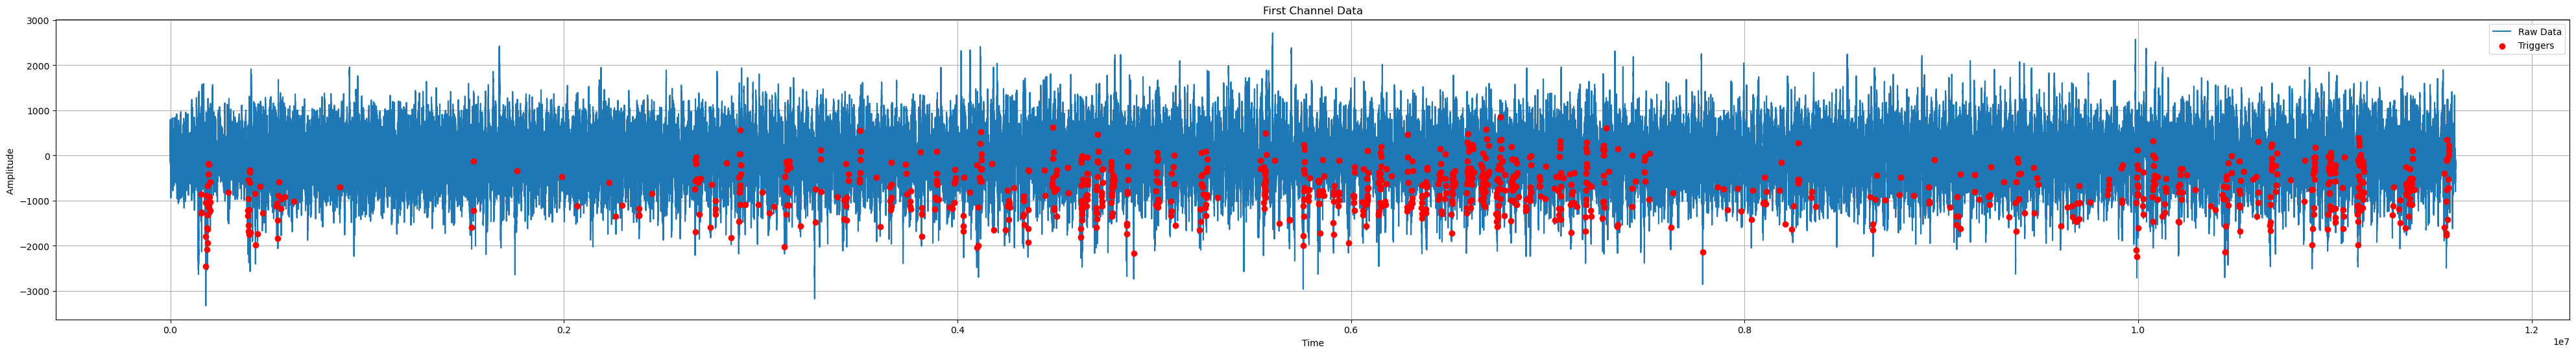

In [11]:
import matplotlib.pyplot as plt
import spikeforest as sf
import numpy as np

uri=None
# uri="sha1://1cdf1934f056d954a7fcea9de5adb1314959ce40/HYBRID_JANELIA.json"
# uri="sha1://bda7c096bce9d137a13dfd6c152d528b5be90501/hybrid_drift_tetrode.json"
# uri="sha1://929735e1bc5ec5751c5fdf1ccf0c138648240ea8/rec_4c_600s_22.firings_true.json"
# uri="sha1://d869b4e67e64b4e27e3f4866bb17c5c1c0262f3a/1103_1_1.json"
# uri="sha1://7e0dac4a7decc26cc0a1c4792e4160c02898c5f9/raw.mda?manifest=ecefb43e013f9c4a983aabb5aa4d0ae63d18a1f8"
# uri="sha1://05536d7a37efb3f5f2ca42c987964f199305f480/20160415_patch2.json"
# uri="sha1://a205f87cef8b7f86df7a09cddbc79a1fbe5df60f/2014_11_25_Pair_3_0.json"
# uri=
# uri=
# uri=
# uri=
# uri=
# R = sf.load_spikeforest_recording(study_name='hybrid_drift_siprobe', recording_name='rec_16c_1200s_11', 
R = sf.load_spikeforest_recording(study_name='paired_boyden32c', recording_name='1103_1_1', 
                                  uri=uri)
print(f'{R.study_set_name}/{R.study_name}/{R.recording_name}')
print(f'Num. channels: {R.num_channels}')
print(f'Duration (sec): {R.duration_sec}')
print(f'Sampling frequency (Hz): {R.sampling_frequency}')
print(f'Num. true units: {R.num_true_units}')
print('')

recording = R.get_recording_extractor()
sorting_true = R.get_sorting_true_extractor()

# 이 파일의 함수들 참고
# /home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/spikeforest/load_extractors/load_recording_extractor.py
# /home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/spikeforest/load_extractors/load_sorting_extractor.py
# /home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/spikeforest/load_extractors/MdaRecordingExtractorV2/MdaRecordingExtractorV2.py

print('trace_shape', recording.get_traces().shape)
print('')

print(f'Recording extractor info: {recording.get_num_channels()} channels, {recording.get_sampling_frequency()} Hz, {recording.get_total_duration()} sec')
print(f'Sorting extractor info: unit ids = {sorting_true.get_unit_ids()}, {sorting_true.get_sampling_frequency()} Hz')
print('')
for unit_id in sorting_true.get_unit_ids():
    st = sorting_true.get_unit_spike_train(unit_id=unit_id)
    print(f'Unit {unit_id}: {len(st)} events')
    print(st)
    print()
print('')
print('Channel locations:')
print(recording.get_channel_locations().shape)


truth = st
one_channel = recording.get_traces()[:,0]
# truth = truth[(truth >= slice // 2) & (truth < slice)] - slice // 2

# 플로팅
plt.figure(figsize=(50, 6))
plt.plot(np.arange(len(one_channel)) , one_channel, zorder = 50, label="Raw Data")  
plt.title("First Channel Data")
plt.xlabel("Time")
plt.ylabel("Amplitude ")
plt.grid(True)
# 트리거 시간 표시 (x축에 표시)
plt.scatter(truth, one_channel[truth], zorder = 120, color='r', label="Triggers")  
plt.legend()
plt.show()


# lindi (deprecated)

In [12]:
## lindi에서 바로 갖고오기 (이거 안씀 왜냐면 미리 다운하는 법 모르겠음)
# # https://dandiarchive.org/dandiset/000618/draft
# # https://neurosift.app/?p=/nwb&url=https://api.dandiarchive.org/api/assets/34a21ebe-c756-4da4-a30b-f1a838a6430b/download/&dandisetId=000618&dandisetVersion=draft
# # https://dandiarchive.org/dandiset/000618/draft/files?location=sub-hybrid-janelia&page=1

# import lindi

# url = 'https://lindi.neurosift.org/dandi/dandisets/000618/assets/34a21ebe-c756-4da4-a30b-f1a838a6430b/nwb.lindi.json'

# # Load the remote file
# f = lindi.LindiH5pyFile.from_lindi_file(url)

# # load the neurodata object
# X = f['/acquisition/ElectricalSeries']

# starting_time = X['starting_time'][()]
# rate = X['starting_time'].attrs['rate']
# data = X['data']

# print(f'starting_time: {starting_time}')
# print(f'rate: {rate}')
# print(f'data shape: {data.shape}')

# import lindi

# url = 'https://lindi.neurosift.org/dandi/dandisets/000618/assets/34a21ebe-c756-4da4-a30b-f1a838a6430b/nwb.lindi.json'

# # Load the remote file
# f = lindi.LindiH5pyFile.from_lindi_file(url)

# # load the neurodata object
# X = f['/units']

# id = X['id']
# spike_times = X['spike_times']
# spike_times_index = X['spike_times_index']

# print(f'Shape of id: {id.shape}')
# print(f'Shape of spike_times: {spike_times.shape}')
# print(f'Shape of spike_times_index: {spike_times_index.shape}')

# print(spike_times[:])
# print(spike_times_index[:][0])

# Hybrid-Janelia

In [13]:
## DANDI에서 NWB 파일 다운받아서 넣어놓기
# https://dandiarchive.org/dandiset/search?search=ground+truth
# https://dandiarchive.org/dandiset/000618?search=ground%20truth&pos=2
# https://pynwb.readthedocs.io/en/latest/tutorials/general/plot_file.html#sphx-glr-tutorials-general-plot-file-py
# https://spikeforest.flatironinstitute.org/studyset/HYBRID_JANELIA 이 데이터셋에 대한 설명


# 데이터셋 설명
# https://web.archive.org/web/20220327062401/https://www.kampff-lab.org/ultra-dense-survey
# https://spikeforest.flatironinstitute.org/studyset/HYBRID_JANELIA
# https://github.com/MouseLand/Kilosort/wiki/4.-eMouse-simulator-with-drift 이걸로 dataset 제작했음

# 1200초, 600초 짜리 있고
# 64채널 32채널 16채널 4채널 짜리있음
# 유닛은 74개, 샘플링 레이트 30000Hz

# NWB 파일 처리하기
# https://www.dandiarchive.org/example-notebooks/
# https://github.com/NeurodataWithoutBorders/lindi
# https://pynwb.readthedocs.io/en/latest/tutorials/general/plot_file.html#sphx-glr-tutorials-general-plot-file-py

from pynwb import NWBHDF5IO, NWBFile, TimeSeries
my_file_path = "/data2/spike_sorting/dandi/hybrid-janelia/sub-hybrid-janelia_ses-hybrid-drift-siprobe-rec-16c-1200s-11_ecephys.nwb"
io = NWBHDF5IO(my_file_path, mode='r',)
nwb = io.read()
nwb

/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.1 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.2.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


,location,group,group_name,label,x,y,z
id,,,,,,,
0,unknown,main pynwb.ecephys.ElectrodeGroup at 0x139630026897584\nFields:\n description: main electrode group\n device: Simulation pynwb.device.Device at 0x139630026896576\nFields:\n description: Simulation\n\n location: unknown\n,main,0,43.0,80.0,0.0
1,unknown,main pynwb.ecephys.ElectrodeGroup at 0x139630026897584\nFields:\n description: main electrode group\n device: Simulation pynwb.device.Device at 0x139630026896576\nFields:\n description: Simulation\n\n location: unknown\n,main,1,11.0,80.0,0.0
2,unknown,main pynwb.ecephys.ElectrodeGroup at 0x139630026897584\nFields:\n description: main electrode group\n device: Simulation pynwb.device.Device at 0x139630026896576\nFields:\n description: Simulation\n\n location: unknown\n,main,2,57.0,100.0,0.0
3,unknown,main pynwb.ecephys.ElectrodeGroup at 0x139630026897584\nFields:\n description: main electrode group\n device: Simulation pynwb.device.Device at 0x139630026896576\nFields:\n description: Simulation\n\n location: unknown\n,main,3,27.0,100.0,0.0
,location,group,group_name,label,x,y,z
id,,,,,,,
0,unknown,main pynwb.ecephys.ElectrodeGroup at 0x139630026897584\nFields:\n description: main electrode group\n device: Simulation pynwb.device.Device at 0x139630026896576\nFields:\n description: Simulation\n\n location: unknown\n,main,0,43.0,80.0,0.0
1,unknown,main pynwb.ecephys.ElectrodeGroup at 0x139630026897584\nFields:\n description: main electrode group\n device: Simulation pynwb.device.Device at 0x139630026896576\nFields:\n description: Simulation\n\n location: unknown\n,main,1,11.0,80.0,0.0
2,unknown,main pynwb.ecephys.ElectrodeGroup at 0x139630026897584\nFields:\n description: main electrode group\n device: Simulation pynwb.device.Device at 0x139630026896576\nFields:\n description: Simulation\n\n location: unknown\n,main,2,57.0,100.0,0.0


In [14]:
#Get the fields within the NWB file
nwbFields = nwb.fields
nwbAcquisition = nwb.acquisition
print('nwbFields.keys(): {}\n'.format(nwbFields.keys()))
print('format(nwbAcquisition.keys(): {}\n'.format(nwbAcquisition.keys()))
# print(nwbAcquisition['ElectricalSeries'])
# print(nwbAcquisition['ElectricalSeries'].data)
# print(nwbAcquisition['ElectricalSeries'].data.shape)
print('electrode 위치:',nwbAcquisition['ElectricalSeries'].electrodes.shape) # 이거 electrode 위치임 걍



## raw 데이터 넘파이로 세팅
raw_data = np.array(nwbAcquisition['ElectricalSeries'].data[:]).T
print('Raw data shape:',raw_data.shape)

## Ground truth 세팅
import numpy as np

# ElectricalSeries의 sampling_rate 가져오기
sampling_rate = nwbAcquisition['ElectricalSeries'].rate

# spike_times를 정수화하고 리스트로 저장
spike_times_int_all_units = [
    np.round(np.array(spike_times) * sampling_rate).astype(int)
    for spike_times in nwbFields['units']["spike_times"]
]
print('Ground truth 세팅:',len(spike_times_int_all_units))

nwbFields.keys(): dict_keys(['session_description', 'identifier', 'session_start_time', 'timestamps_reference_time', 'file_create_date', 'experimenter', 'acquisition', 'keywords', 'electrodes', 'electrode_groups', 'devices', 'subject', 'units', 'experiment_description', 'session_id', 'lab', 'institution'])

format(nwbAcquisition.keys(): dict_keys(['ElectricalSeries'])

electrode 위치: (16, 7)
Raw data shape: (16, 36000000)
Ground truth 세팅: 74


raw_data_sliced (16, 150)


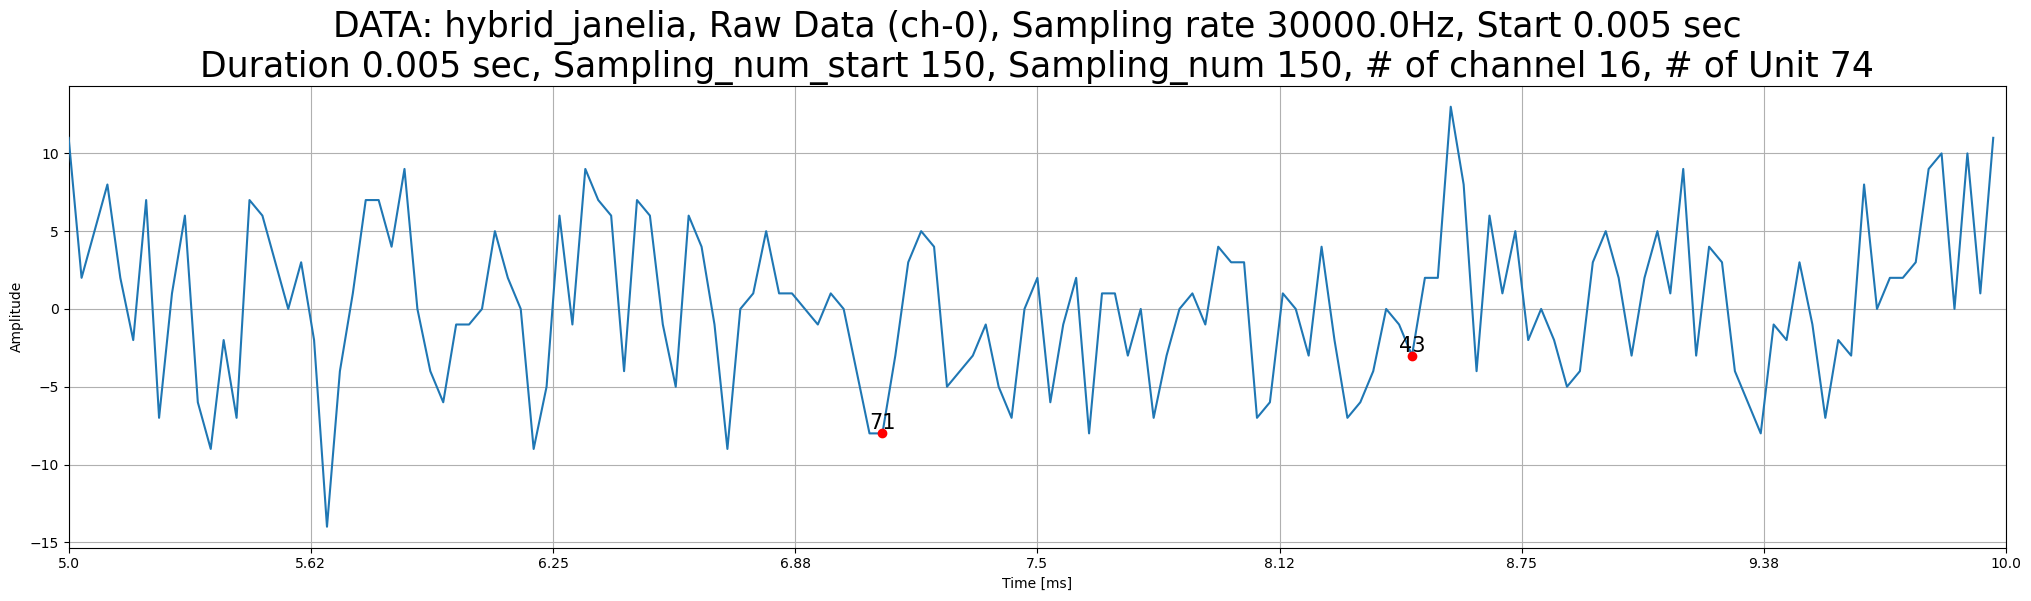

In [15]:
## 데이터 슬라이스 해서 보자 (너무 많잖아)
# for ch in range(raw_data_sliced.shape[0]):
for ch in range(1):
    what_channel = ch
    sampling_start = 0.005 # 초 # 언제부터 볼지
    sampling_second = 0.005 # 초 # 얼마나 볼지
    sampling_rate = nwbAcquisition['ElectricalSeries'].rate

    sampling_num_start = int(sampling_start * sampling_rate)
    sampling_num = int(sampling_second * sampling_rate)

    raw_data_sliced = np.array(raw_data[:, sampling_num_start:sampling_num_start+sampling_num])
    print('raw_data_sliced', raw_data_sliced.shape)

    filtered_spike_times_int_all_units = [np.array(spike_times)[(sampling_num_start <= np.array(spike_times)) & (np.array(spike_times) < sampling_num_start+sampling_num)] for spike_times in spike_times_int_all_units]






    import matplotlib.pyplot as plt
    # 플로팅
    one_channel = raw_data_sliced[what_channel]
    truth = filtered_spike_times_int_all_units

    plt.figure(figsize=(25, 6))
    plt.plot(np.arange(len(one_channel)) , one_channel, zorder = 50, label="Raw Data")  
    plt.xlim(0, sampling_num)
    # 가로축 간격 설정
    x_min, x_max = plt.xlim()  # 현재 x축 범위 가져오기
    x_interval = (x_max-x_min)/8  # 원하는 x축 간격 (데이터 포인트 기준)
    plt.xticks(np.arange(x_min, x_max + x_interval, x_interval))  # 간격에 따라 눈금 설정

    plt.title(f"DATA: {nwb.subject.subject_id}, Raw Data (ch-{what_channel}), Sampling rate {sampling_rate}Hz, Start {sampling_start} sec\nDuration {sampling_second} sec, Sampling_num_start {sampling_num_start}, Sampling_num {sampling_num}, # of channel {nwbAcquisition['ElectricalSeries'].electrodes.shape[0]}, # of Unit {len(spike_times_int_all_units)}", fontsize=25)
    plt.xlabel("Time [ms]")
    plt.ylabel("Amplitude")
    plt.grid(True)

    for idx, spike_times in enumerate(truth):
        spike_times = spike_times - sampling_num_start
        plt.scatter(spike_times, one_channel[spike_times], zorder=120, color='r', label=f"Trigger {idx}")
        for time in spike_times:
            plt.text(time, one_channel[time], str(idx), color='black', zorder=119, fontsize=15, ha='center', va='bottom')


    # x축 눈금 위치는 그대로 두고, 표시되는 숫자만 변경
    xticks = plt.gca().get_xticks()
    new_labels = [round((tick + sampling_num_start) / sampling_rate * 1000, 2) for tick in xticks]
    plt.xticks(ticks=xticks, labels=new_labels)

    plt.show()

# MEAREC Neuropixels

In [16]:
## Simulated cortical Neuropixels recording with ground truth
# https://dandiarchive.org/dandiset/000034/0.211030.0713/files?location=sub-MEAREC-250neuron-Neuropixels&page=1
# https://spikeinterface.github.io/blog/ground-truth-comparison-and-ensemble-sorting-of-a-synthetic-neuropixels-recording/
# 위 링크가 전처리하는 법 알려주긴 함!!!!!!!!!!!!!!!

# 10분, 유닛은 250개, 채널은 384개. 총 19,200,200개의 데이터 포인트, 32,000Hz

# A 10 minute Neuropixels recording simulated using the MEArec Python package (Buccino et al., 2020). 
# The recording contains the spiking activity of 250 biophysically detailed neurons (200 excitatory 
# and 50 inhibitory cells from the Neocortical Micro Circuit Portal with independent Poisson firing patterns, 
# and additive Gaussian noise with 10uV standard deviation.



import numpy as np
from pynwb import NWBHDF5IO, NWBFile, TimeSeries
my_file_path = "/data2/spike_sorting/dandi/spikeinterface-neuropixels/sub-MEAREC-250neuron-Neuropixels_ecephys.nwb"
io = NWBHDF5IO(my_file_path, mode='r',)
nwb = io.read()
nwb

/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/pynwb/ecephys.py:109: UserWarning: ElectricalSeries 'ElectricalSeries': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


,x,y,z,imp,location,filtering,group,group_name,rel_x,rel_y
id,,,,,,,,,,
0,NaN,NaN,NaN,-1.0,unknown,none,0 pynwb.ecephys.ElectrodeGroup at 0x139630024976656\nFields:\n description: electrode_group_description\n device: Device pynwb.device.Device at 0x139630024975456\n location: electrode_group_location\n,0,-24.0,-1910.0
1,NaN,NaN,NaN,-1.0,unknown,none,0 pynwb.ecephys.ElectrodeGroup at 0x139630024976656\nFields:\n description: electrode_group_description\n device: Device pynwb.device.Device at 0x139630024975456\n location: electrode_group_location\n,0,-24.0,-1870.0
2,NaN,NaN,NaN,-1.0,unknown,none,0 pynwb.ecephys.ElectrodeGroup at 0x139630024976656\nFields:\n description: electrode_group_description\n device: Device pynwb.device.Device at 0x139630024975456\n location: electrode_group_location\n,0,-24.0,-1830.0
3,NaN,NaN,NaN,-1.0,unknown,none,0 pynwb.ecephys.ElectrodeGroup at 0x139630024976656\nFields:\n description: electrode_group_description\n device: Device pynwb.device.Device at 0x139630024975456\n location: electrode_group_location\n,0,-24.0,-1790.0
,x,y,z,imp,location,filtering,group,group_name,rel_x,rel_y
id,,,,,,,,,,
0,NaN,NaN,NaN,-1.0,unknown,none,0 pynwb.ecephys.ElectrodeGroup at 0x139630024976656\nFields:\n description: electrode_group_description\n device: Device pynwb.device.Device at 0x139630024975456\n location: electrode_group_location\n,0,-24.0,-1910.0
1,NaN,NaN,NaN,-1.0,unknown,none,0 pynwb.ecephys.ElectrodeGroup at 0x139630024976656\nFields:\n description: electrode_group_description\n device: Device pynwb.device.Device at 0x139630024975456\n location: electrode_group_location\n,0,-24.0,-1870.0
2,NaN,NaN,NaN,-1.0,unknown,none,0 pynwb.ecephys.ElectrodeGroup at 0x139630024976656\nFields:\n description: electrode_group_description\n device: Device pynwb.device.Device at 0x139630024975456\n location: electrode_group_location\n,0,-24.0,-1830.0


In [17]:
#Get the fields within the NWB file
nwbFields = nwb.fields
nwbAcquisition = nwb.acquisition
print(nwb.acquisition['ElectricalSeries'].comments,'\n',nwb.subject.subject_id)
print('\n\n nwb 프린트=====================================================\n',nwb, '==================================================\n')
# print('nwbFields.keys(): {}\n'.format(nwbFields.keys()))
# print('format(nwbAcquisition.keys(): {}\n'.format(nwbAcquisition.keys()))
# print(nwbAcquisition['ElectricalSeries'])
# print(nwbAcquisition['ElectricalSeries'].data)
# print(nwbAcquisition['ElectricalSeries'].data.shape)
print('electrode 위치:',nwbAcquisition['ElectricalSeries'].electrodes.shape) # 이거 electrode 위치임 걍


# ElectricalSeries의 sampling_rate 가져오기
sampling_rate = nwbAcquisition['ElectricalSeries'].rate

## Ground truth 세팅
# spike_times를 정수화하고 리스트로 저장
spike_times_int_all_units = [
    np.round(np.array(spike_times) * sampling_rate).astype(int)
    for spike_times in nwbFields['units']["spike_times"]
]
print('Ground truth 세팅:',len(spike_times_int_all_units))

print('Raw 데이터 세팅은 밑 셀에서')

Generated from SpikeInterface::NwbRecordingExtractor 
 MEAREC_250neuron_Neuropixels


 nwb 프린트=====================================================
 root pynwb.file.NWBFile at 0x139630024976944
Fields:
  acquisition: {
    ElectricalSeries <class 'pynwb.ecephys.ElectricalSeries'>
  }
  devices: {
    Device <class 'pynwb.device.Device'>
  }
  electrode_groups: {
    0 <class 'pynwb.ecephys.ElectrodeGroup'>
  }
  electrodes: electrodes <class 'hdmf.common.table.DynamicTable'>
  file_create_date: [datetime.datetime(2020, 7, 27, 9, 46, 20, 620378, tzinfo=tzoffset(None, 3600))]
  identifier: 8f43bf0f-edb0-45cc-93eb-9acad8f2a84c
  session_description: no description
  session_start_time: 2020-07-27 09:46:20.619184+01:00
  subject: subject pynwb.file.Subject at 0x139630025221696
Fields:
  subject_id: MEAREC_250neuron_Neuropixels

  timestamps_reference_time: 2020-07-27 09:46:20.619184+01:00
  units: units <class 'pynwb.misc.Units'>

electrode 위치: (384, 10)
Ground truth 세팅: 250
Raw 데이터 세팅은 밑 

Sliced raw data shape: (384, 160)


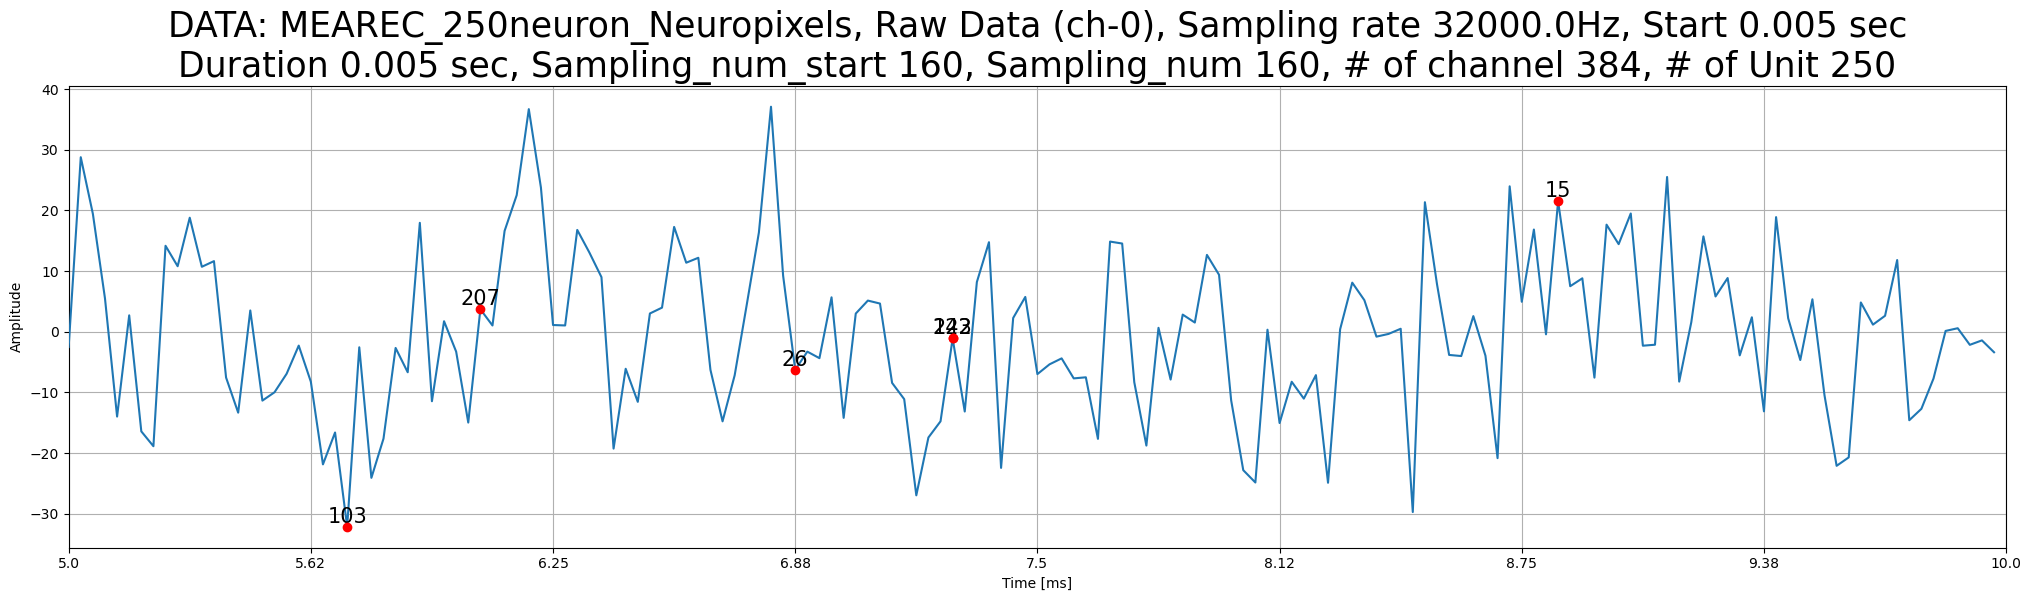

In [18]:
## 데이터 슬라이스 해서 보자 (너무 많잖아)
# for ch in range(raw_data_sliced.shape[0]):
for ch in range(1):
    what_channel = ch
    sampling_start = 0.005 # 초 # 언제부터 볼지
    sampling_second = 0.005 # 초 # 얼마나 볼지
    sampling_rate = nwbAcquisition['ElectricalSeries'].rate

    sampling_num_start = int(sampling_start * sampling_rate)
    sampling_num = int(sampling_second * sampling_rate)

    
    # raw 데이터 넘파이로 세팅
    raw_data_sliced = np.array(nwbAcquisition['ElectricalSeries'].data[sampling_num_start:sampling_num_start+sampling_num]).T
    print('Sliced raw data shape:',raw_data_sliced.shape)


    filtered_spike_times_int_all_units = [np.array(spike_times)[(sampling_num_start <= np.array(spike_times)) & (np.array(spike_times) < sampling_num_start+sampling_num)] for spike_times in spike_times_int_all_units]





    import matplotlib.pyplot as plt
    # 플로팅
    one_channel = raw_data_sliced[what_channel]
    truth = filtered_spike_times_int_all_units

    plt.figure(figsize=(25, 6))
    plt.plot(np.arange(len(one_channel)) , one_channel, zorder = 50, label="Raw Data")  
    plt.xlim(0, sampling_num)
    # 가로축 간격 설정
    x_min, x_max = plt.xlim()  # 현재 x축 범위 가져오기
    x_interval = (x_max-x_min)/8  # 원하는 x축 간격 (데이터 포인트 기준)
    plt.xticks(np.arange(x_min, x_max + x_interval, x_interval))  # 간격에 따라 눈금 설정

    plt.title(f"DATA: {nwb.subject.subject_id}, Raw Data (ch-{what_channel}), Sampling rate {sampling_rate}Hz, Start {sampling_start} sec\nDuration {sampling_second} sec, Sampling_num_start {sampling_num_start}, Sampling_num {sampling_num}, # of channel {nwbAcquisition['ElectricalSeries'].electrodes.shape[0]}, # of Unit {len(spike_times_int_all_units)}", fontsize=25)
    plt.xlabel("Time [ms]")
    plt.ylabel("Amplitude")
    plt.grid(True)

    for idx, spike_times in enumerate(truth):
        spike_times = spike_times - sampling_num_start
        plt.scatter(spike_times, one_channel[spike_times], zorder=120, color='r', label=f"Trigger {idx}")
        for time in spike_times:
            plt.text(time, one_channel[time], str(idx), color='black', zorder=119, fontsize=15, ha='center', va='bottom')


    # x축 눈금 위치는 그대로 두고, 표시되는 숫자만 변경
    xticks = plt.gca().get_xticks()
    new_labels = [round((tick + sampling_num_start) / sampling_rate * 1000, 2) for tick in xticks]
    plt.xticks(ticks=xticks, labels=new_labels)

    plt.show()

# Neuropixels 2016

In [35]:
# channel 129, unit 7, 25000Hz, 45분정도되는데 일단 5분만 가져옴.

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import io

In [40]:
data_path = '/data2/spike_sorting/neuropixels_choi'
filename = ["/set1/20141202_all_es", "/set2/20150924_1_e", "/set3/20150601_all_s", "/set4/20150924_1_GT"]

index = 2 #데이터 선택해 0 1 2 3 

n_channel = 129
n_unit = 7 if index != 2 else 8 # set3는 예외적으로 unit 8개다.
sampling_rate = 25000

In [41]:
# merge된 raw data 로드
current_dataset = data_path+filename[index]+'_merged.npy'
raw_data = np.load(current_dataset)

In [42]:
# 그라운드 트루스 로드
ground_truth_path = data_path+filename[index]+'_gtTimes.mat'
mat1 = io.loadmat(ground_truth_path)

spike_times_int_all_units = []
for i in range(n_unit):
    spike_times_int_all_units.append(mat1['gtTimes'][0][i][:,0])


spike_chans_int_all_units = []
for i in range(n_unit):
    spike_chans_int_all_units.append(mat1['gtChans'][0][i][:,0])

print('Raw data shape:',raw_data.shape)
print('len(spike_times_int_all_units):',len(spike_times_int_all_units))
print('len(spike_times_int_all_units):',len(spike_chans_int_all_units))
print('\nspike_times_int_all_units:',spike_chans_int_all_units)


Raw data shape: (129, 7500000)
len(spike_times_int_all_units): 8
len(spike_times_int_all_units): 8

spike_times_int_all_units: [array([28, 27, 26, 24, 23, 22, 60, 55, 56, 57, 58, 59], dtype=uint8), array([ 77,  68, 100,  79,  78,  67,  66,  99, 111], dtype=uint8), array([29, 30, 17, 18, 19, 62, 63, 64, 50, 51, 52], dtype=uint8), array([ 94,  95,  96,  83,  84, 125, 126, 127, 128, 114, 115, 116],
      dtype=uint8), array([ 75,  76,  77,  69,  70,  74, 106, 107, 108, 109, 101, 102, 103],
      dtype=uint8), array([ 75,  76,  77,  68,  69,  70, 107, 108, 109, 100, 101, 102],
      dtype=uint8), array([ 76,  77,  68,  69,  70, 108, 109, 100, 101, 102,  78,  67,  99,
       111], dtype=uint8), array([ 92,  86,  87,  88,  90,  91, 124, 119, 120, 122, 123], dtype=uint8)]


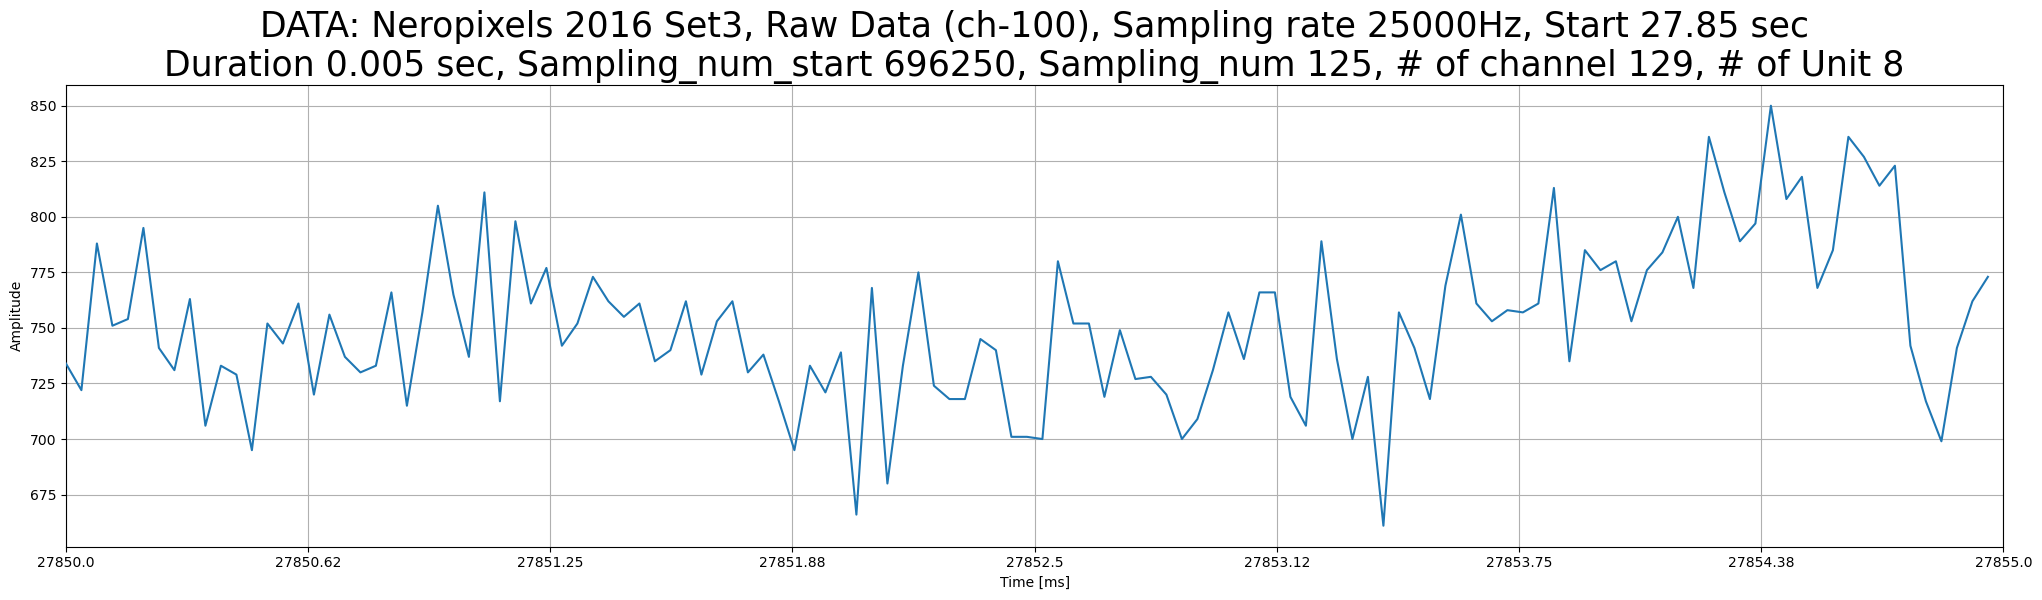

In [44]:
## 데이터 슬라이스 해서 보자 (너무 많잖아)
# for ch in range(raw_data.shape[0]):
want_to_look_ch = 100
how_many_ch = 1
for ch in range(want_to_look_ch,want_to_look_ch+how_many_ch):
    what_channel = ch
    sampling_start = 27.850 # 초 # 언제부터 볼지
    sampling_second =0.005 # 초 # 얼마나 볼지
    sampling_rate = sampling_rate

    sampling_num_start = int(sampling_start * sampling_rate)
    sampling_num = int(sampling_second * sampling_rate)

    raw_data_sliced = raw_data[:, sampling_num_start:sampling_num_start+sampling_num]
    # print('raw_data_sliced', raw_data_sliced.shape)

    filtered_spike_times_int_all_units = [np.array(spike_times)[(sampling_num_start <= np.array(spike_times)) & (np.array(spike_times) < sampling_num_start+sampling_num)] for spike_times in spike_times_int_all_units]




    import matplotlib.pyplot as plt
    # 플로팅
    one_channel = raw_data_sliced[what_channel]
    truth = filtered_spike_times_int_all_units

    plt.figure(figsize=(25, 6))
    plt.plot(np.arange(len(one_channel)) , one_channel, zorder = 50, label="Raw Data")  
    plt.xlim(0, sampling_num)
    # 가로축 간격 설정
    x_min, x_max = plt.xlim()  # 현재 x축 범위 가져오기
    x_interval = (x_max-x_min)/8  # 원하는 x축 간격 (데이터 포인트 기준)
    plt.xticks(np.arange(x_min, x_max + x_interval, x_interval))  # 간격에 따라 눈금 설정

    plt.title(f"DATA: {'Neropixels 2016 Set'}{index+1}, Raw Data (ch-{what_channel}), Sampling rate {sampling_rate}Hz, Start {sampling_start} sec\nDuration {sampling_second} sec, Sampling_num_start {sampling_num_start}, Sampling_num {sampling_num}, # of channel {raw_data.shape[0]}, # of Unit {len(spike_times_int_all_units)}", fontsize=25)
    plt.xlabel("Time [ms]")
    plt.ylabel("Amplitude")
    plt.grid(True)

    for idx, spike_times in enumerate(truth):
        spike_times = spike_times - sampling_num_start
        scatter_color = 'purple' if what_channel in spike_chans_int_all_units[idx] else 'red'
        plt.scatter(spike_times, one_channel[spike_times], zorder=120, color=scatter_color, label=f"Trigger {idx}")
        for time in spike_times:
            plt.text(time, one_channel[time], str(idx), color='black', zorder=125, fontsize=15, ha='center', va='bottom')


    # x축 눈금 위치는 그대로 두고, 표시되는 숫자만 변경
    xticks = plt.gca().get_xticks()
    new_labels = [round((tick + sampling_num_start) / sampling_rate * 1000, 2) for tick in xticks]
    plt.xticks(ticks=xticks, labels=new_labels)

    plt.show()

# spike_interace의 sub-mouse412804

In [25]:
# https://dandiarchive.org/dandiset/000034/0.211030.0713/files?location=sub-mouse412804&page=1
# 여기 또 데이터셋 있긴함. 
# 필요하면 구해봐.

# spikeforest의 snr구하는 코드

In [26]:
# https://github.com/flatironinstitute/spikeforest2/blob/master/spikeforest2/processing/_compute_units_info.py


# import json
# import hither_sf as hither
# import numpy as np
# from spikeforest2_utils import AutoRecordingExtractor, AutoSortingExtractor

# @hither.function('compute_units_info', version='0.1.0')
# @hither.input_file('sorting_path')
# @hither.output_file('json_out')
# @hither.container(default='docker://magland/spikeforest2:0.1.1')
# @hither.local_module('../../spikeforest2_utils')
# def compute_units_info(recording_path, sorting_path, json_out):
#     recording = AutoRecordingExtractor(recording_path)
#     sorting = AutoSortingExtractor(sorting_path, samplerate=recording.get_sampling_frequency())
#     obj = _compute_units_info(recording=recording, sorting=sorting)
#     with open(json_out, 'w') as f:
#         json.dump(obj, f)

# def _compute_units_info(*, recording, sorting, channel_ids=[], unit_ids=[]):
#     import spikeextractors as se
#     import spiketoolkit as st

#     if (channel_ids) and (len(channel_ids) > 0):
#         recording = se.SubRecordingExtractor(parent_recording=recording, channel_ids=channel_ids)

#     # load into memory
#     print('Loading recording into RAM...')
#     recording = se.NumpyRecordingExtractor(timeseries=recording.get_traces(), sampling_frequency=recording.get_sampling_frequency())

#     # do filtering
#     print('Filtering...')
#     recording = st.preprocessing.bandpass_filter(recording=recording, freq_min=300, freq_max=6000)
#     recording = se.NumpyRecordingExtractor(timeseries=recording.get_traces(), sampling_frequency=recording.get_sampling_frequency())

#     if (not unit_ids) or (len(unit_ids) == 0):
#         unit_ids = sorting.get_unit_ids()

#     print('Computing channel noise levels...')
#     channel_noise_levels = _compute_channel_noise_levels(recording=recording)

#     # No longer use subset to compute the templates
#     print('Computing unit templates...')
#     templates = _compute_unit_templates(recording=recording, sorting=sorting, unit_ids=unit_ids, max_num=100)

#     print(recording.get_channel_ids())

#     ret = []
#     for i, unit_id in enumerate(unit_ids):
#         print('Unit {} of {} (id={})'.format(i + 1, len(unit_ids), unit_id))
#         template = templates[i]
#         max_p2p_amps_on_channels = np.max(template, axis=1) - np.min(template, axis=1)
#         peak_channel_index = np.argmax(max_p2p_amps_on_channels)
#         peak_channel = recording.get_channel_ids()[peak_channel_index]
#         peak_signal = np.max(np.abs(template[peak_channel_index, :]))
#         info0 = dict()
#         info0['unit_id'] = int(unit_id)
#         info0['snr'] = peak_signal / channel_noise_levels[peak_channel_index]
#         info0['peak_channel'] = int(recording.get_channel_ids()[peak_channel])
#         train = sorting.get_unit_spike_train(unit_id=unit_id)
#         info0['num_events'] = int(len(train))
#         info0['firing_rate'] = float(len(train) / (recording.get_num_frames() / recording.get_sampling_frequency()))
#         ret.append(info0)
#     return ret

# def _compute_channel_noise_levels(recording):
#     channel_ids = recording.get_channel_ids()
#     # M=len(channel_ids)
#     samplerate = int(recording.get_sampling_frequency())
#     X = recording.get_traces(start_frame=samplerate * 1, end_frame=samplerate * 2)
#     ret = []
#     for ii in range(len(channel_ids)):
#         # noise_level=np.std(X[ii,:])
#         noise_level = np.median(np.abs(X[ii, :])) / 0.6745  # median absolute deviation (MAD)
#         ret.append(noise_level)
#     return ret

# def _compute_unit_templates(*, recording, sorting, unit_ids, snippet_len=50, max_num=100, channels=None):
#     ret = []
#     for unit in unit_ids:
#         # print('Unit {} of {}'.format(unit,len(unit_ids)))
#         waveforms = _get_random_spike_waveforms(recording=recording, sorting=sorting, unit=unit, snippet_len=snippet_len, max_num=max_num, channels=None)
#         template = np.median(waveforms, axis=2)
#         ret.append(template)
#     return ret

# def _get_random_spike_waveforms(*, recording, sorting, unit, snippet_len, max_num, channels=None):
#     st = sorting.get_unit_spike_train(unit_id=unit)
#     num_events = len(st)
#     if num_events > max_num:
#         event_indices = np.random.choice(range(num_events), size=max_num, replace=False)
#     else:
#         event_indices = range(num_events)

#     spikes = recording.get_snippets(reference_frames=st[event_indices].astype(int), snippet_len=snippet_len, channel_ids=channels)
#     if len(spikes) > 0:
#         spikes = np.dstack(tuple(spikes))
#     else:
#         spikes = np.zeros((recording.get_num_channels(), snippet_len, 0))
#     return spikes
